In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from src import Netlist, LumpedElement, WDFScheme
from src import Resistor, Inductor, Capacitor, VoltageSource, Diode, LinearTransformer

In [2]:
class OutputVoltage:
    def __init__(self, samplerate: int, voltages: np.ndarray | list[float]) -> None:
        self._samplerate: int = samplerate
        self._times: np.ndarray = np.arange(len(voltages)) / samplerate
        self._voltages: np.ndarray = voltages
        self._use_input: bool = False

    def add_input(self, inputs: np.ndarray) -> 'OutputVoltage':
        self._use_input = True
        self._inputs = inputs
        return self
    
    def show(self) -> None:
        plt.figure(figsize=(10, 6))
        plt.grid()
        if self._use_input:
            plt.plot(self._times, self._voltages, label="Output")
            plt.plot(self._times, self._inputs, label="Input", linestyle="dashed")
            plt.legend()
        else:
            plt.plot(self._times, self._voltages)
        plt.xlim(0, max(self._times))
        plt.title("Circuit voltages")
        plt.xlabel("Time [sec]")
        plt.ylabel("Voltage [V]")
        plt.show()

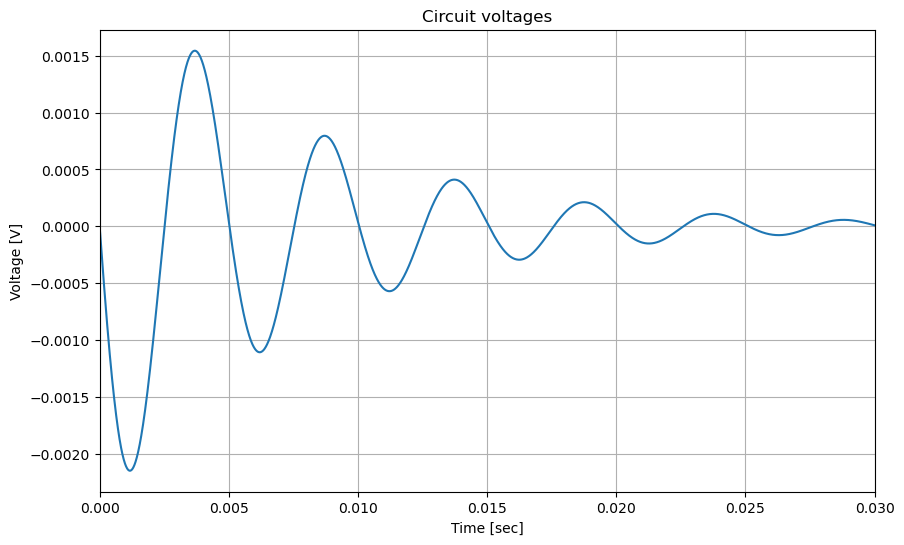

In [3]:
# oscillating circuit
# T = 2 * pi * sqrt(L * C) - Thomson's formula
# let's select L = C, such as T = 0.005 s
T = 0.005
L = C = T / (2 * np.pi)
oscillator: Netlist = Netlist(
    LumpedElement("v", VoltageSource(100), (0, 1)),
    LumpedElement("c", Capacitor(C), (0, 1)),
    LumpedElement("i", Inductor(L), (2, 0)),
    LumpedElement("r", Resistor(0.2), (1, 2))   # resistor to make oscillations fade out
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, oscillator)
# short impulse to charge capacitor a bit
charge: list = [100] + [0] * 3000
oscillations = wdf.process_signal({"v": charge}, keys=["r"])["r"]
OutputVoltage(samplerate, oscillations).show()

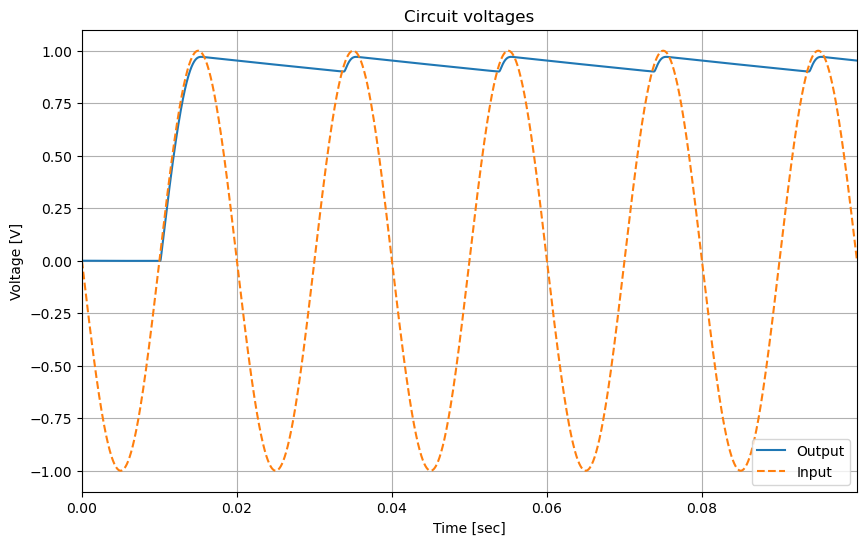

In [4]:
# diode envelope detector (as AC-DC converter)
envelope: Netlist = Netlist(
    LumpedElement("v", VoltageSource(1e-3), (0, 1)),
    LumpedElement("d", Diode(-3e-5, -6e-3), (0, 2)),
    LumpedElement("c", Capacitor(0.25e-3), (1, 2)),
    LumpedElement("r1", Resistor(1e3), (2, 3)),
    LumpedElement("r2", Resistor(1), (1, 3)),
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, envelope)
# 50 Hz alternating current (AC)
n_samples = 10000
ac_voltage = -np.sin(2 * 50 * np.pi * np.arange(n_samples) / samplerate)
dc_voltage = wdf.process_signal({"v": ac_voltage}, keys=["r1"])["r1"]
OutputVoltage(samplerate, dc_voltage).add_input(ac_voltage).show()

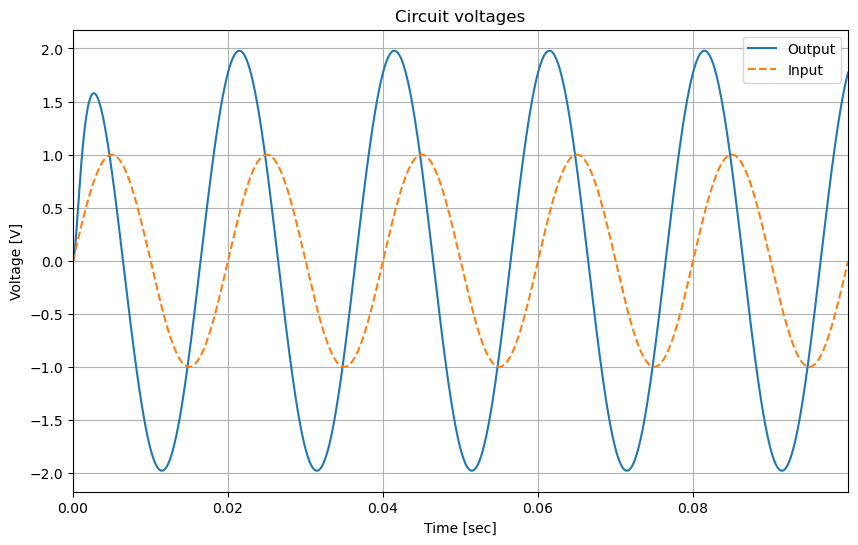

In [5]:
# step-up transformer
transformer: Netlist = Netlist(
    LumpedElement("v", VoltageSource(1e-3), (0, 1)),
    LumpedElement("tr", LinearTransformer(1e-6, 0.5e-3, 0.3), (0, 1, 2, 3)),
    LumpedElement("r", Resistor(1), (2, 3))
)

samplerate: int = 100000
wdf: WDFScheme = WDFScheme(samplerate, transformer)
# 50 Hz alternating current (AC)
n_samples = 10000
ac_voltage = np.sin(2 * 50 * np.pi * np.arange(n_samples) / samplerate)
outputs = wdf.process_signal({"v": ac_voltage}, keys=["r"])["r"]
OutputVoltage(samplerate, outputs).add_input(ac_voltage).show()